# Analysing the distance between marginal distributions after PCA for CheXpert models trained with high capacity teacher

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn import decomposition
import numpy as np
from scipy import stats
from scipy.spatial import distance
from statsmodels.stats.multitest import multipletests
np.set_printoptions(suppress=True,formatter={'float_kind': '{:f}'.format})
plt.rcParams['figure.dpi'] = 250

In [8]:
def create_pca(
        embeds_array: np.ndarray,
        model_df: pd.DataFrame
    ):
    
    # n -> number of samples
    # m -> number of features
    n, m = embeds_array.shape
    pca = decomposition.PCA(n_components=0.99, whiten=False)
    embeds_pca = pca.fit_transform(embeds_array)

    mu = pca.mean_
    U = pca.components_.T
    D = pca.singular_values_**2 / (n - 1)
    exp_var = pca.explained_variance_ratio_

    model_df['PCA 1'] = embeds_pca[:,0]
    model_df['PCA 2'] = embeds_pca[:,1]
    model_df['PCA 3'] = embeds_pca[:,2]
    model_df['PCA 4'] = embeds_pca[:,3]

    # Replace numerical labels with categorical
    model_df['Targets'] = model_df['Targets'].replace({0: 'No finding', 1: 'Other'})
    model_df['Sex'] = model_df['Sex'].replace({0: 'Male', 1: 'Female'})
    model_df['Age'] = model_df['Age'].replace({0: '<60', 1: '60+'})
    model_df['Race'] = model_df['Race'].replace({0: 'White', 1: 'Non-White'})

In [9]:
from scipy.stats import gaussian_kde

def create_sim_table(
    df: pd.DataFrame,
):
    
    def js_simlarity(marginal, samples):
        df_female = samples[samples['Sex'] == 'Female']
        df_male = samples[samples['Sex'] == 'Male']
        df_young = samples[samples['Age'] == '<60']
        df_old = samples[samples['Age'] == '60+']
        df_white = samples[samples['Race'] == 'White']
        df_non_white = samples[samples['Race'] == 'Non-White']
        df_no_fnd = samples[samples['Targets'] == 'No finding']
        df_other = samples[samples['Targets'] == 'Other']

        def get_js_distance(data_1, data_2):
            # Generate an array of 1000 values between the min and max of both datasets. This serve as the range over which PDFs will be estimated
            x = np.linspace(min(np.min(data_1), np.min(data_2)), max(np.max(data_1), np.max(data_2)), num=1000)

            # Compute Univariate Kernel Density Estimate for both datasets
            pdf1 = gaussian_kde(data_1)(x)
            pdf2 = gaussian_kde(data_2)(x)

            # Normalise
            pdf1 /= np.sum(pdf1)
            pdf2 /= np.sum(pdf2)

            # To avoid div by 0
            epsilon = 1e-10
            pdf1 += epsilon
            pdf2 += epsilon

            return distance.jensenshannon(pdf1, pdf2, base=2)

        sim_label = get_js_distance(df_no_fnd[marginal], df_other[marginal])
        sim_age = get_js_distance(df_young[marginal], df_old[marginal])
        sim_sex = get_js_distance(df_male[marginal], df_female[marginal])
        sim_race = get_js_distance(df_white[marginal], df_non_white[marginal])

        return [sim_label, sim_sex, sim_age, sim_race]
    
    sim_pca1 = js_simlarity('PCA 1', df)
    sim_pca2 = js_simlarity('PCA 2', df)
    sim_pca3 = js_simlarity('PCA 3', df)
    sim_pca4 = js_simlarity('PCA 4', df)

    index = ['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4']
    columns = ['label_dist', 'sex_dist', 'age_dist', 'race_dist']
    df_sim = pd.DataFrame([sim_pca1, sim_pca2, sim_pca3, sim_pca4], index=index, columns=columns)

    return df_sim
    


In [10]:
MODEL_FEATURES = {
    'resnet18': 512,
    'resnet34': 512,
    'resnet50': 2048,
    'resnet101': 2048,
}
RANDOM_STATE = 42

# PCA Modes similarity before & after KD

In [11]:
def pca_comparison_data(
    model_dir: str,
    is_student: bool,
    is_kd: bool,
    is_teacher: bool,
    teacher_id: str = None,
):
    # Look for the folders that have 'sam1' in them

    # TODO: THIS WORKS ONLY FOR STUDENT MODELS BUT I THINK WE ONLY DO RANDOM WEIGHTED SAMPLING
    if is_student:
        folders = [f for f in os.listdir(model_dir) if 'sam1' in f and ('r18' in f or 'r34' in f)]
    else:
        folders = [f for f in os.listdir(model_dir) if 'sam1' in f]


    if is_teacher:
        folders = [f for f in folders if teacher_id in f]

    if is_kd:
        assert teacher_id is not None
        folders = [f for f in folders if teacher_id in f]

    # Go to each folder and load 'embeds.csv' and 'test_predictions.csv'
    data = []
    for folder in folders:
        df = pd.read_csv(f'{model_dir}/{folder}/test.csv')

        # Create PCA
        embeds_df = pd.read_csv(f'{model_dir}/{folder}/embeds.csv')
        embeds = np.array(embeds_df.iloc[:,0:MODEL_FEATURES[df['model_name'].iloc[0]]])

        create_pca(embeds, embeds_df)
        sim_df = create_sim_table(embeds_df)
        sim_df = sim_df.reset_index()
        sim_df = sim_df.rename(columns={'index': 'PCA'})

        sim_df['avg_subgroup_sim'] = (sim_df['sex_dist'] + sim_df['race_dist'] + sim_df['age_dist']) / 3
        sim_df['model_id'] = df['model_id'].iloc[0]
        sim_df['model_name'] = df['model_name'].iloc[0]
        sim_df['teacher_id'] = df['teacher_id'].iloc[0]
        sim_df['teacher_name'] = df['teacher_name'].iloc[0]

        data.append(sim_df)

        # if len(data) == 2:
        #     break

    df = pd.concat(data)
    return df


In [12]:
no_female = pca_comparison_data(
    model_dir='../../results/chexpert_no_female/resnet',
    is_student = True,
    is_kd = False,
    is_teacher = False,
)
print(no_female.shape)
no_female_kd = pca_comparison_data(
    model_dir='../../results/chexpert_no_female/kd',
    is_student = True,
    is_kd = True,
    teacher_id='r101-sam1-s46',
    is_teacher = False,
)
print(no_female_kd.shape)
no_female_feature = pca_comparison_data(
    model_dir='../../results/chexpert_no_female/kd-feature_rgb',
    is_student = True,
    is_kd = True,
    teacher_id='r101-sam1-s46',
    is_teacher = False,
)
print(no_female_feature.shape)
no_female_attention = pca_comparison_data(
    model_dir='../../results/chexpert_no_female/attention_kd',
    is_student = True,
    is_kd = True,
    teacher_id='r101-sam1-s46',
    is_teacher = False,
)
print(no_female_attention.shape)



no_old = pca_comparison_data(
    model_dir='../../results/chexpert_no_old/resnet',
    is_student = True,
    is_kd = False,
    is_teacher = False,
)
print(no_old.shape)
no_old_kd = pca_comparison_data(
    model_dir='../../results/chexpert_no_old/kd',
    is_student = True,
    is_kd = True,
    teacher_id='r101-sam1-s46',
    is_teacher = False,
)
print(no_old_kd.shape)
no_old_feature = pca_comparison_data(
    model_dir='../../results/chexpert_no_old/kd-feature_rgb',
    is_student = True,
    is_kd = True,
    teacher_id='r101-sam1-s46',
    is_teacher = False,
)
print(no_old_feature.shape)
no_old_attention = pca_comparison_data(
    model_dir='../../results/chexpert_no_old/attention_kd',
    is_student = True,
    is_kd = True,
    teacher_id='r101-sam1-s46',
    is_teacher = False,
)
print(no_old_attention.shape)



no_white = pca_comparison_data(
    model_dir='../../results/chexpert_no_white/resnet',
    is_student = True,
    is_kd = False,
    is_teacher = False,
)
print(no_white.shape)
no_white_kd = pca_comparison_data(
    model_dir='../../results/chexpert_no_white/kd',
    is_student = True,
    is_kd = True,
    teacher_id='r101-sam1-s46',
    is_teacher = False,
)
print(no_white_kd.shape)
no_white_feature = pca_comparison_data(
    model_dir='../../results/chexpert_no_white/kd-feature_rgb',
    is_student = True,
    is_kd = True,
    teacher_id='r101-sam1-s46',
    is_teacher = False,
)
print(no_white_feature.shape)
no_white_attention = pca_comparison_data(
    model_dir='../../results/chexpert_no_white/attention_kd',
    is_student = True,
    is_kd = True,
    teacher_id='r101-sam1-s46',
    is_teacher = False,
)
print(no_white_attention.shape)



teacher_df = pca_comparison_data(
    model_dir='../../results/chexpert/resnet',
    is_student = False,
    is_kd = False,
    is_teacher = True,
    teacher_id='r101-sam1-s46',
)
print(teacher_df.shape)

(40, 10)
(40, 10)
(40, 10)
(40, 10)
(40, 10)
(40, 10)
(40, 10)
(40, 10)
(40, 10)
(40, 10)
(40, 10)
(40, 10)
(4, 10)


In [18]:
def plot_similarity_grouped_barplot(
    teacher_df: pd.DataFrame,
    students_df_kd: pd.DataFrame,
    students_df_feature: pd.DataFrame,
    students_df_attention: pd.DataFrame,
    metric: str,
    title: str = '',
):
    sns.set(font_scale=1.2)
    sns.set_style("whitegrid")

    # Prepare KD data
    # r18_before_kd = students_df_kd[(students_df_kd['model_name'] == 'resnet18') & pd.isna(students_df_kd['teacher_id'])]
    # r18_before_kd['label'] = 'Avg Resnet18 w/o KD'
    # r18_after_kd = students_df_kd[(students_df_kd['model_name'] == 'resnet18') & pd.notna(students_df_kd['teacher_id'])]
    # r18_after_kd['label'] = 'Avg Resnet18 w/ KD'
    # r34_before_kd = students_df_kd[(students_df_kd['model_name'] == 'resnet34') & pd.isna(students_df_kd['teacher_id'])]
    # r34_before_kd['label'] = 'Avg Resnet34 w/o KD'
    # r34_after_kd = students_df_kd[(students_df_kd['model_name'] == 'resnet34') & pd.notna(students_df_kd['teacher_id'])]
    # r34_after_kd['label'] = 'Avg Resnet34 w/ KD'


    # Prepare KD data
    before_kd = students_df_kd[pd.isna(students_df_kd['teacher_id'])]
    before_kd['label'] = 'Avg w/o KD'
    after_kd = students_df_kd[pd.notna(students_df_kd['teacher_id'])]
    after_kd['label'] = 'Avg w/ Vanilla KD'

    feature_after = students_df_feature[pd.notna(students_df_feature['teacher_id'])]
    feature_after['label'] = 'Avg w/ Feature KD'

    attention_after = students_df_attention[pd.notna(students_df_attention['teacher_id'])]
    attention_after['label'] = 'Avg w/ Attention KD'

    teacher_df['label'] = 'Teacher'

    # df = pd.concat([teacher_df, r18_before_kd, r18_after_kd, r34_before_kd, r34_after_kd])
    df = pd.concat([teacher_df, before_kd, after_kd, feature_after, attention_after])

    colors = ["salmon", "wheat", "sienna", "plum", "purple"]
    colors = ["salmon", "lightskyblue", "orange", "forestgreen", "purple"]

    # --------- only for display - not needed for the actual plot ------------

    df = df.drop(columns=['avg_subgroup_sim'])
    display_df = df.groupby(['PCA', 'label']).mean()
    display(display_df.round(3))


    def compute_difference(df, column):
        pivot_df = df.pivot_table(index='label', columns='PCA', values=column)
        diff_df = pivot_df.subtract(pivot_df.loc['Teacher'], axis=1)
        diff_df = diff_df.stack().reset_index(name=f'{column}_diff')
        diff_df = diff_df[diff_df['label'] != 'Teacher']
        return diff_df

    columns_to_diff = [col for col in display_df.columns if col not in ['PCA', 'label']]
    result_df = compute_difference(display_df, columns_to_diff[0])
    for col in columns_to_diff[1:]:
        diff_df = compute_difference(df, col)
        result_df = pd.merge(result_df, diff_df, on=['PCA', 'label'])
    result_df = result_df.set_index(['label', 'PCA'])
    display(result_df.round(3))


    g = sns.catplot(
        data=df, kind="bar",
        x="PCA", y=metric, hue="label", errorbar="sd", height=6, estimator=np.mean, aspect=1.5, capsize=0.05, errwidth=1.2, palette=colors,
    )

    g.ax.set_axisbelow(True)

    # Set the custom y-scale
    min_val = df[metric].min()
    max_val = df[metric].max()
    plt.ylim(min_val - 0.05 * abs(min_val), max_val + 0.05 * abs(max_val))
    # plt.ylim(0, 0.2)

    # Add horizontal grid lines and make them dotted
    g.ax.yaxis.grid(True, linestyle='dotted')

    # Add border
    g.ax.spines['top'].set_visible(True)
    g.ax.spines['right'].set_visible(True)


    # Set titles
    plt.xlabel('')
    plt.title(title)

    # Move the legend outside and adjust its position
    # plt.tight_layout()  # Ensures the plot and legend do not overlap
    # legend.set_bbox_to_anchor((1.02, 0.5))  # Adjust the coordinates for desired positioning


    # Add a gap between bars in the same group
    for bar_container in g.ax.containers:
        for bar in bar_container:
            x = bar.get_x()
            width = bar.get_width()
            centre = x + width / 2.

            bar.set_x(centre - (0.8 * width / 2.))  # 0.9 controls the size of the gap; smaller values create a bigger gap
            bar.set_width(0.8 * width)  # The bar width is reduced to 90% to create the gap

    plt.rcParams['figure.dpi'] = 100
    plt.show()

### Plot

In [19]:
no_female['data'] = 'no female'
no_female_kd['data'] = 'no female'
no_female_feature['data'] = 'no female'
no_female_attention['data'] = 'no female'

no_old['data'] = 'no old'
no_old_kd['data'] = 'no old'
no_old_feature['data'] = 'no old'
no_old_attention['data'] = 'no old'

no_white['data'] = 'no white'
no_white_kd['data'] = 'no white'
no_white_feature['data'] = 'no white'
no_white_attention['data'] = 'no white'

student_df = pd.concat([no_female, no_female_kd, no_old, no_old_kd, no_white, no_white_kd])
student_feature = pd.concat([no_female, no_female_feature, no_old, no_old_feature, no_white, no_white_feature])
student_attention = pd.concat([no_female, no_female_attention, no_old, no_old_attention, no_white, no_white_attention])

student_feature.head()

,PCA,label_dist,sex_dist,age_dist,race_dist,avg_subgroup_sim,model_id,model_name,teacher_id,teacher_name,data
0,PCA 1,0.470365,0.046861,0.163697,0.034519,0.081692,r34-sam1-s46,resnet34,NaN,NaN,no female
1,PCA 2,0.251239,0.112004,0.115703,0.062043,0.096583,r34-sam1-s46,resnet34,NaN,NaN,no female
2,PCA 3,0.142335,0.060480,0.163845,0.036123,0.086816,r34-sam1-s46,resnet34,NaN,NaN,no female
3,PCA 4,0.268652,0.077031,0.099686,0.038205,0.071641,r34-sam1-s46,resnet34,NaN,NaN,no female
0,PCA 1,0.510824,0.119371,0.191955,0.067538,0.126288,r18-sam1-s44,resnet18,NaN,NaN,no female


### All Unfair Datasets Averaged

/tmp/ipykernel_2939534/4020165433.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_kd['label'] = 'Avg w/o KD'
/tmp/ipykernel_2939534/4020165433.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_kd['label'] = 'Avg w/ Vanilla KD'
/tmp/ipykernel_2939534/4020165433.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

label_dist  sex_dist  age_dist  race_dist
PCA   label                                                         
PCA 1 Avg w/ Attention KD       0.546     0.050     0.211      0.041
      Avg w/ Feature KD         0.549     0.049     0.218      0.041
      Avg w/ Vanilla KD         0.546     0.041     0.216      0.045
      Avg w/o KD                0.512     0.063     0.192      0.039
      Teacher                   0.557     0.055     0.218      0.044
PCA 2 Avg w/ Attention KD       0.213     0.080     0.113      0.061
      Avg w/ Feature KD         0.239     0.061     0.120      0.056
      Avg w/ Vanilla KD         0.189     0.119     0.078      0.047
      Avg w/o KD                0.254     0.121     0.133      0.075
      Teacher                   0.345     0.065     0.129      0.028
PCA 3 Avg w/ Attention KD       0.192     0.147     0.086      0.086
      Avg w/ Feature KD         0.195     0.078     0.092      0.058
      Avg w/ Vanilla KD         0.205     0.143     0.104      0.082
      Avg w/o KD                0.190     0.128     0.115      0.086
      Teacher                   0.293     0.075     0.161      0.091
PCA 4 Avg w/ Attention KD       0.182     0.123     0.089      0.068
      Avg w/ Feature KD         0.211     0.090     0.116      0.058
      Avg w/ Vanilla KD         0.191     0.112     0.095      0.068
      Avg w/o KD                0.183     0.135     0.091      0.068
      Teacher                   0.287     0.043     0.188      0.054

label_dist_diff  sex_dist_diff  age_dist_diff  \
label               PCA                                                    
Avg w/ Attention KD PCA 1           -0.010         -0.005         -0.007   
                    PCA 2           -0.132          0.015         -0.016   
                    PCA 3           -0.101          0.073         -0.075   
                    PCA 4           -0.105          0.081         -0.099   
Avg w/ Feature KD   PCA 1           -0.008         -0.006         -0.000   
                    PCA 2           -0.106         -0.004         -0.009   
                    PCA 3           -0.098          0.004         -0.069   
                    PCA 4           -0.076          0.047         -0.071   
Avg w/ Vanilla KD   PCA 1           -0.011         -0.013         -0.002   
                    PCA 2           -0.156          0.054         -0.051   
                    PCA 3           -0.087          0.068         -0.057   
                    PCA 4           -0.096          0.070         -0.093   
Avg w/o KD          PCA 1           -0.044          0.008         -0.026   
                    PCA 2           -0.090          0.057          0.004   
                    PCA 3           -0.103          0.054         -0.046   
                    PCA 4           -0.105          0.092         -0.096   

                           race_dist_diff  
label               PCA                    
Avg w/ Attention KD PCA 1          -0.003  
                    PCA 2           0.033  
                    PCA 3          -0.005  
                    PCA 4           0.013  
Avg w/ Feature KD   PCA 1          -0.003  
                    PCA 2           0.027  
                    PCA 3          -0.032  
                    PCA 4           0.004  
Avg w/ Vanilla KD   PCA 1           0.001  
                    PCA 2           0.019  
                    PCA 3          -0.008  
                    PCA 4           0.013  
Avg w/o KD          PCA 1          -0.006  
                    PCA 2           0.047  
                    PCA 3          -0.005  
                    PCA 4           0.014

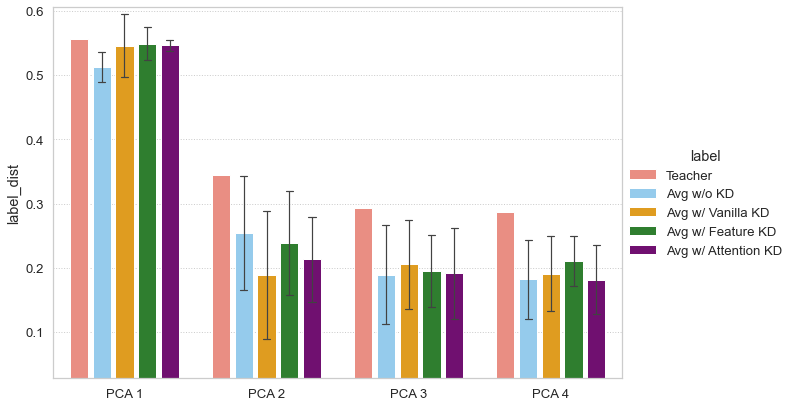

/tmp/ipykernel_2939534/4020165433.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_kd['label'] = 'Avg w/o KD'
/tmp/ipykernel_2939534/4020165433.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_kd['label'] = 'Avg w/ Vanilla KD'
/tmp/ipykernel_2939534/4020165433.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

label_dist  sex_dist  age_dist  race_dist
PCA   label                                                         
PCA 1 Avg w/ Attention KD       0.546     0.050     0.211      0.041
      Avg w/ Feature KD         0.549     0.049     0.218      0.041
      Avg w/ Vanilla KD         0.546     0.041     0.216      0.045
      Avg w/o KD                0.512     0.063     0.192      0.039
      Teacher                   0.557     0.055     0.218      0.044
PCA 2 Avg w/ Attention KD       0.213     0.080     0.113      0.061
      Avg w/ Feature KD         0.239     0.061     0.120      0.056
      Avg w/ Vanilla KD         0.189     0.119     0.078      0.047
      Avg w/o KD                0.254     0.121     0.133      0.075
      Teacher                   0.345     0.065     0.129      0.028
PCA 3 Avg w/ Attention KD       0.192     0.147     0.086      0.086
      Avg w/ Feature KD         0.195     0.078     0.092      0.058
      Avg w/ Vanilla KD         0.205     0.143     0.104      0.082
      Avg w/o KD                0.190     0.128     0.115      0.086
      Teacher                   0.293     0.075     0.161      0.091
PCA 4 Avg w/ Attention KD       0.182     0.123     0.089      0.068
      Avg w/ Feature KD         0.211     0.090     0.116      0.058
      Avg w/ Vanilla KD         0.191     0.112     0.095      0.068
      Avg w/o KD                0.183     0.135     0.091      0.068
      Teacher                   0.287     0.043     0.188      0.054

label_dist_diff  sex_dist_diff  age_dist_diff  \
label               PCA                                                    
Avg w/ Attention KD PCA 1           -0.010         -0.005         -0.007   
                    PCA 2           -0.132          0.015         -0.016   
                    PCA 3           -0.101          0.073         -0.075   
                    PCA 4           -0.105          0.081         -0.099   
Avg w/ Feature KD   PCA 1           -0.008         -0.006         -0.000   
                    PCA 2           -0.106         -0.004         -0.009   
                    PCA 3           -0.098          0.004         -0.069   
                    PCA 4           -0.076          0.047         -0.071   
Avg w/ Vanilla KD   PCA 1           -0.011         -0.013         -0.002   
                    PCA 2           -0.156          0.054         -0.051   
                    PCA 3           -0.087          0.068         -0.057   
                    PCA 4           -0.096          0.070         -0.093   
Avg w/o KD          PCA 1           -0.044          0.008         -0.026   
                    PCA 2           -0.090          0.057          0.004   
                    PCA 3           -0.103          0.054         -0.046   
                    PCA 4           -0.105          0.092         -0.096   

                           race_dist_diff  
label               PCA                    
Avg w/ Attention KD PCA 1          -0.003  
                    PCA 2           0.033  
                    PCA 3          -0.005  
                    PCA 4           0.013  
Avg w/ Feature KD   PCA 1          -0.003  
                    PCA 2           0.027  
                    PCA 3          -0.032  
                    PCA 4           0.004  
Avg w/ Vanilla KD   PCA 1           0.001  
                    PCA 2           0.019  
                    PCA 3          -0.008  
                    PCA 4           0.013  
Avg w/o KD          PCA 1          -0.006  
                    PCA 2           0.047  
                    PCA 3          -0.005  
                    PCA 4           0.014

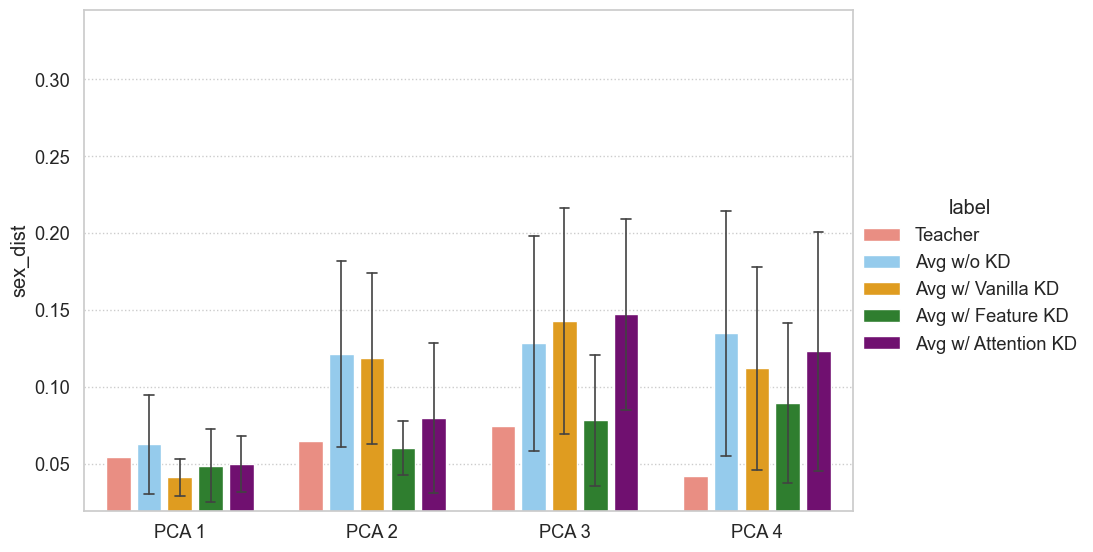

/tmp/ipykernel_2939534/4020165433.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_kd['label'] = 'Avg w/o KD'
/tmp/ipykernel_2939534/4020165433.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_kd['label'] = 'Avg w/ Vanilla KD'
/tmp/ipykernel_2939534/4020165433.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

label_dist  sex_dist  age_dist  race_dist
PCA   label                                                         
PCA 1 Avg w/ Attention KD       0.546     0.050     0.211      0.041
      Avg w/ Feature KD         0.549     0.049     0.218      0.041
      Avg w/ Vanilla KD         0.546     0.041     0.216      0.045
      Avg w/o KD                0.512     0.063     0.192      0.039
      Teacher                   0.557     0.055     0.218      0.044
PCA 2 Avg w/ Attention KD       0.213     0.080     0.113      0.061
      Avg w/ Feature KD         0.239     0.061     0.120      0.056
      Avg w/ Vanilla KD         0.189     0.119     0.078      0.047
      Avg w/o KD                0.254     0.121     0.133      0.075
      Teacher                   0.345     0.065     0.129      0.028
PCA 3 Avg w/ Attention KD       0.192     0.147     0.086      0.086
      Avg w/ Feature KD         0.195     0.078     0.092      0.058
      Avg w/ Vanilla KD         0.205     0.143     0.104      0.082
      Avg w/o KD                0.190     0.128     0.115      0.086
      Teacher                   0.293     0.075     0.161      0.091
PCA 4 Avg w/ Attention KD       0.182     0.123     0.089      0.068
      Avg w/ Feature KD         0.211     0.090     0.116      0.058
      Avg w/ Vanilla KD         0.191     0.112     0.095      0.068
      Avg w/o KD                0.183     0.135     0.091      0.068
      Teacher                   0.287     0.043     0.188      0.054

label_dist_diff  sex_dist_diff  age_dist_diff  \
label               PCA                                                    
Avg w/ Attention KD PCA 1           -0.010         -0.005         -0.007   
                    PCA 2           -0.132          0.015         -0.016   
                    PCA 3           -0.101          0.073         -0.075   
                    PCA 4           -0.105          0.081         -0.099   
Avg w/ Feature KD   PCA 1           -0.008         -0.006         -0.000   
                    PCA 2           -0.106         -0.004         -0.009   
                    PCA 3           -0.098          0.004         -0.069   
                    PCA 4           -0.076          0.047         -0.071   
Avg w/ Vanilla KD   PCA 1           -0.011         -0.013         -0.002   
                    PCA 2           -0.156          0.054         -0.051   
                    PCA 3           -0.087          0.068         -0.057   
                    PCA 4           -0.096          0.070         -0.093   
Avg w/o KD          PCA 1           -0.044          0.008         -0.026   
                    PCA 2           -0.090          0.057          0.004   
                    PCA 3           -0.103          0.054         -0.046   
                    PCA 4           -0.105          0.092         -0.096   

                           race_dist_diff  
label               PCA                    
Avg w/ Attention KD PCA 1          -0.003  
                    PCA 2           0.033  
                    PCA 3          -0.005  
                    PCA 4           0.013  
Avg w/ Feature KD   PCA 1          -0.003  
                    PCA 2           0.027  
                    PCA 3          -0.032  
                    PCA 4           0.004  
Avg w/ Vanilla KD   PCA 1           0.001  
                    PCA 2           0.019  
                    PCA 3          -0.008  
                    PCA 4           0.013  
Avg w/o KD          PCA 1          -0.006  
                    PCA 2           0.047  
                    PCA 3          -0.005  
                    PCA 4           0.014

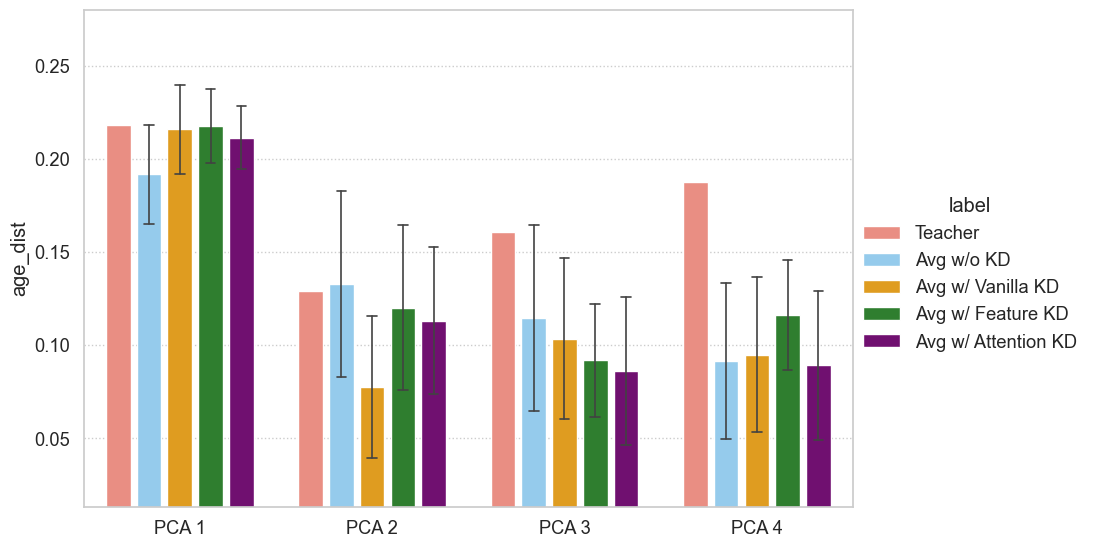

/tmp/ipykernel_2939534/4020165433.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_kd['label'] = 'Avg w/o KD'
/tmp/ipykernel_2939534/4020165433.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_kd['label'] = 'Avg w/ Vanilla KD'
/tmp/ipykernel_2939534/4020165433.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

label_dist  sex_dist  age_dist  race_dist
PCA   label                                                         
PCA 1 Avg w/ Attention KD       0.546     0.050     0.211      0.041
      Avg w/ Feature KD         0.549     0.049     0.218      0.041
      Avg w/ Vanilla KD         0.546     0.041     0.216      0.045
      Avg w/o KD                0.512     0.063     0.192      0.039
      Teacher                   0.557     0.055     0.218      0.044
PCA 2 Avg w/ Attention KD       0.213     0.080     0.113      0.061
      Avg w/ Feature KD         0.239     0.061     0.120      0.056
      Avg w/ Vanilla KD         0.189     0.119     0.078      0.047
      Avg w/o KD                0.254     0.121     0.133      0.075
      Teacher                   0.345     0.065     0.129      0.028
PCA 3 Avg w/ Attention KD       0.192     0.147     0.086      0.086
      Avg w/ Feature KD         0.195     0.078     0.092      0.058
      Avg w/ Vanilla KD         0.205     0.143     0.104      0.082
      Avg w/o KD                0.190     0.128     0.115      0.086
      Teacher                   0.293     0.075     0.161      0.091
PCA 4 Avg w/ Attention KD       0.182     0.123     0.089      0.068
      Avg w/ Feature KD         0.211     0.090     0.116      0.058
      Avg w/ Vanilla KD         0.191     0.112     0.095      0.068
      Avg w/o KD                0.183     0.135     0.091      0.068
      Teacher                   0.287     0.043     0.188      0.054

label_dist_diff  sex_dist_diff  age_dist_diff  \
label               PCA                                                    
Avg w/ Attention KD PCA 1           -0.010         -0.005         -0.007   
                    PCA 2           -0.132          0.015         -0.016   
                    PCA 3           -0.101          0.073         -0.075   
                    PCA 4           -0.105          0.081         -0.099   
Avg w/ Feature KD   PCA 1           -0.008         -0.006         -0.000   
                    PCA 2           -0.106         -0.004         -0.009   
                    PCA 3           -0.098          0.004         -0.069   
                    PCA 4           -0.076          0.047         -0.071   
Avg w/ Vanilla KD   PCA 1           -0.011         -0.013         -0.002   
                    PCA 2           -0.156          0.054         -0.051   
                    PCA 3           -0.087          0.068         -0.057   
                    PCA 4           -0.096          0.070         -0.093   
Avg w/o KD          PCA 1           -0.044          0.008         -0.026   
                    PCA 2           -0.090          0.057          0.004   
                    PCA 3           -0.103          0.054         -0.046   
                    PCA 4           -0.105          0.092         -0.096   

                           race_dist_diff  
label               PCA                    
Avg w/ Attention KD PCA 1          -0.003  
                    PCA 2           0.033  
                    PCA 3          -0.005  
                    PCA 4           0.013  
Avg w/ Feature KD   PCA 1          -0.003  
                    PCA 2           0.027  
                    PCA 3          -0.032  
                    PCA 4           0.004  
Avg w/ Vanilla KD   PCA 1           0.001  
                    PCA 2           0.019  
                    PCA 3          -0.008  
                    PCA 4           0.013  
Avg w/o KD          PCA 1          -0.006  
                    PCA 2           0.047  
                    PCA 3          -0.005  
                    PCA 4           0.014

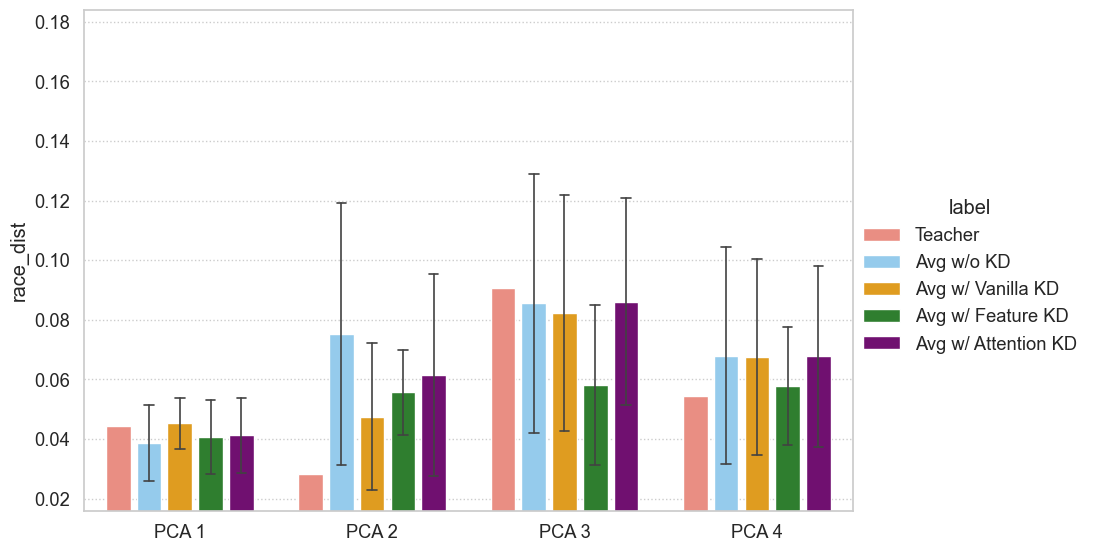

In [20]:
# TODO: Can do each dataset seperetely

plot_similarity_grouped_barplot(
    teacher_df,
    student_df,
    student_feature,
    student_attention,
    metric='label_dist'
)

plot_similarity_grouped_barplot(
    teacher_df,
    student_df,
    student_feature,
    student_attention,
    metric='sex_dist'
)

plot_similarity_grouped_barplot(
    teacher_df,
    student_df,
    student_feature,
    student_attention,
    metric='age_dist'
)

plot_similarity_grouped_barplot(
    teacher_df,
    student_df,
    student_feature,
    student_attention,
    metric='race_dist'
)